# Lecture 11 - Lagrange Relaxation

Joseph Paat

*Acknowledgment:* Code taken from Lecture 1 of COMM612 by Prof. Julia Yan.
Lazy DFJ implementation adapted from the [JuMP documentation](https://jump.dev/JuMP.jl/stable/tutorials/algorithms/tsp_lazy_constraints/).

##  Header

In [1]:
# # Dependencies: Uncomment and run this cell if you don't have these packages 
# Pkg.add("LKH")
# Pkg.add("JuMP")
# Pkg.add("Gurobi")
# Pkg.add("Combinatorics")
# Pkg.add("Plots")
# Pkg.add("Graphs")
# Pkg.add("SimpleWeightedGraphs")

In [2]:
include("../01-tsp/src/data.jl");
include("../01-tsp/src/opt.jl");
include("../01-tsp/src/out.jl");
include("src/hk.jl")
using LKH

## Data Input
Generate five TSP instances on 250 nodes.

In [3]:
n = 250
dat = Dict()
for iter in 1:5
    dat[iter] = TSPInstance(n, random_seed = iter, int = true)
end

Let's first try the DFJ formulation with lazy constraints, from Lecture 1.

In [4]:
env = Gurobi.Env()
optimizer = JuMP.optimizer_with_attributes(
    () -> Gurobi.Optimizer(env), 
    "TimeLimit" => 10); 

mdl_dfj = TSPModel(dat[1], optimizer = optimizer)
add_dfj_callback!(mdl_dfj)
solution_dfj = solve!(mdl_dfj)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-18
Set parameter TimeLimit to value 10
Set parameter TimeLimit to value 10
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.3.0 23D56)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 63250 rows, 62500 columns and 250000 nonzeros
Model fingerprint: 0x80668216
Variable types: 0 continuous, 62500 integer (62500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 31625 rows and 250 columns
Presolve time: 0.22s
Presolved: 31625 rows, 62250 columns, 186750 nonzeros
Variable types: 0 continuous, 62250 integer (62250 binary)
Root relaxation presolved: 31626 rows, 62250 columns, 186762 nonzeros

Deterministic concurrent LP optimizer: pr

Nothing

On my computer, this runs out of time.

# Comparing the heuristic to the lower bound by Held Karp

We now compare the Lin-Kernighan Heuristic to the Held-Karp value on random 250-city instances.

In [5]:
# Store the LKH and HK values
opt_vals = Dict([("LKH",[]),("HK",[])])

for iter in keys(dat)
    
    # Lin-Kernighan Heuristic
    @time lk_opt_tour, lk_opt_len = LKH.solve_tsp(Matrix{Int}(dat[iter].d))

    # Held-Karp bound
    @time hk_bound_val = hk_bound(dat[iter], lk_opt_len)
    
    push!(opt_vals["LKH"], lk_opt_len)
    push!(opt_vals["HK"], hk_bound_val)

end

  5.416809 seconds (178.71 k allocations: 9.990 MiB, 0.57% compilation time)
  2.288528 seconds (3.84 M allocations: 172.542 MiB, 0.77% gc time, 3.46% compilation time)
  4.850993 seconds (88.78 k allocations: 5.401 MiB)
  2.041124 seconds (3.51 M allocations: 157.963 MiB, 1.14% gc time)
  6.006830 seconds (88.81 k allocations: 5.401 MiB)
  2.178094 seconds (3.82 M allocations: 171.446 MiB, 0.30% gc time)
  8.719838 seconds (88.89 k allocations: 5.406 MiB)
  2.172386 seconds (3.82 M allocations: 171.446 MiB, 0.23% gc time)
  3.324872 seconds (88.73 k allocations: 5.399 MiB)
  2.030898 seconds (3.51 M allocations: 157.963 MiB, 0.31% gc time)


Plot results

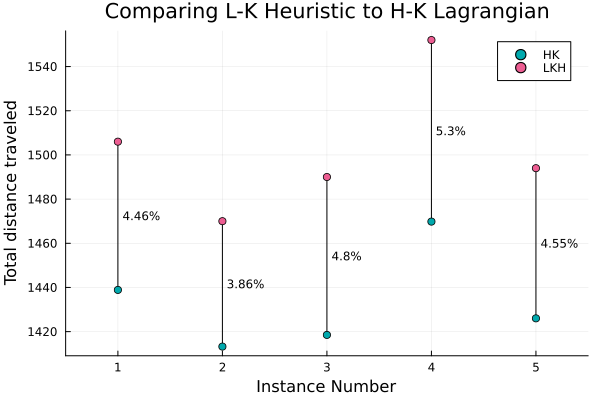

In [6]:
plt = Plots.plot()
# Plot connecting lines and text annotation
for it in keys(dat)
    # Connecting lines
    Plots.plot!(
        [it for key in keys(opt_vals)],
        [opt_vals[key][it] for key in keys(opt_vals)],
    linecolor = "black", label = false)
    lkh_it = opt_vals["LKH"][it]
    hk_it = opt_vals["HK"][it]
    rel_gap = round((abs(lkh_it - hk_it)/lkh_it)*100, digits=2)
    # Text label
    annotate!(it+0.05, (lkh_it+hk_it)/2, 
        text(string(rel_gap) * "%", :black, :left, 8))
end
# Plot points for upper and lower bounds
for bnd in keys(opt_vals)
    Plots.scatter!(opt_vals[bnd], label = bnd, marker = :circle)   
end
xlims!(0.5, length(dat) + 0.5)
    
title!("Comparing L-K Heuristic to H-K Lagrangian")
xlabel!("Instance Number")
ylabel!("Total distance traveled")
display(plt)